In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json._normalize import nested_to_record
import json
import wandb
from omegaconf import OmegaConf

%matplotlib inline

In [3]:
pull_from_wandb = False

In [4]:
if pull_from_wandb:
    doctor_path = "/gpfs/data/oermannlab/users/lavender/NYUTron_hf/src/finetune_models/readmission/compare_with_doctors/inference/result/metric_comparison_new.csv"
    keep = (
        [f"doctor_{n+1}" for n in range(6)]
        + ["nyutron_max_f1_label"]
        + ["median_doctor"]
    )
    doctors = pd.read_csv(doctor_path, index_col=0)
    doctors = doctors[doctors.competitor.isin(keep)]
    doctors

In [5]:
if pull_from_wandb:
    small_case_auc = pd.read_csv(
        "/gpfs/data/oermannlab/users/lavender/NYUTron_hf/src/finetune_models/readmission/compare_with_doctors/inference/result/20_cases_auc_new.csv",
        index_col=0,
    )
    small_case_auc

## gather data df

In [6]:
if pull_from_wandb:
    username = "lavender"
    project_name = "eval_threshold"
    artifact_names = ["temporal_auc", "prognostic_auc"]
    api = wandb.Api()

    def artifact_to_df(artifact):
        local_path = artifact.file()
        f = open(local_path)
        data = json.load(f)
        df = pd.DataFrame(data=data["data"], columns=data["columns"])
        return df

    def combine_df(artifact_dfs, small_df, trials=["semi-prospective", "prospective"]):
        print("combining...")
        artifact_subs = []
        for idx, artifact_df in enumerate(artifact_dfs):
            artifact_sub = artifact_df[["fpr", "tpr"]]
            artifact_sub["trial"] = trials[idx]
            print(artifact_sub)
            artifact_subs.append(artifact_sub)
        small_sub = small_df[["fpr", "tpr"]]
        small_sub["trial"] = "retrospective-sample"
        print(small_sub)
        combined = pd.concat(artifact_subs + [small_sub], ignore_index=True)
        return combined

In [10]:
if pull_from_wandb:
    dfs = []
    for artifact_name in artifact_names:
        artifact = api.artifact(f"{username}/{project_name}/{artifact_name}:v0")
        df = artifact_to_df(artifact)
        dfs.append(df)
    print("*****df*****")
    print(dfs)
    print("****small auc*****")
    print(small_case_auc)
    combined = combine_df(dfs, small_case_auc)
    combined_sub = combined[combined.trial == "retrospective-sample"]
    combined_sub["trial"] = combined_sub["trial"].replace(
        {"retrospective-sample": "nyutron"}
    )
    print(combined)
    print("************")
    legend = ["physician"] * 6 + ["nyutron", "median physician"]
    doctors["predictor"] = legend
    print(doctors)
    print("************")
    combined_sub["trial"] = "nyutron-auc"
    print(combined_sub)
    doctors.to_csv("raw_data/3a_scatter.csv")
    combined_sub.to_csv("raw_data/3a_auc.csv")
else:
    doctors = pd.read_csv("raw_data/3a_scatter.csv", index_col=0)
    combined_sub = pd.read_csv("raw_data/3a_auc.csv", index_col=0)

In [11]:
palette = sns.color_palette("Set2", 9)
palette = [palette[0], palette[1], palette[2], palette[6]]
palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451)]

In [14]:
plt_conf = OmegaConf.load("nature.yaml")
slack = 5
single_col_width = 89 - slack
double_col_width = 183 - slack
height = 89 - slack


def mm_to_inch(mm):
    return mm / 25.4


print(plt_conf)

{'axes.labelsize': 7, 'xtick.labelsize': 7, 'ytick.labelsize': 7, 'legend.fontsize': 7, 'font.size': 7, 'font.family': 'sans-serif', 'font.sans-serif': 'Arial, Helvetica', 'mathtext.fontset': 'dejavusans', 'axes.linewidth': 0.5, 'grid.linewidth': 0.5, 'lines.linewidth': 1.0, 'lines.markersize': 3, 'pdf.fonttype': 42, 'ps.fonttype': 42, 'svg.fonttype': 'none'}


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


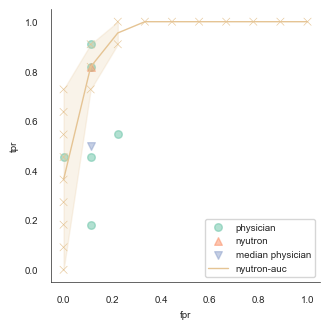

In [31]:
sns.set(font_scale=3, style="white")
marker_size = 30
plt.rcParams.update(plt_conf)
sns.lmplot(
    x="fpr",
    y="tpr",
    data=doctors,
    hue="predictor",
    fit_reg=False,
    markers=["o", "^", "v"],
    legend=False,
    palette=palette[:3],
    scatter_kws={"s": marker_size, "alpha": 0.5},
    height=mm_to_inch(height),
    aspect=1,
)
ax = sns.lineplot(
    x="fpr",
    y="tpr",
    data=combined_sub,
    hue="trial",
    palette=[palette[3]],
    errorbar=lambda x: (x.min(), x.max()),
)
sns.scatterplot(
    x="fpr",
    y="tpr",
    data=combined_sub,
    hue="trial",
    palette=[palette[3]],
    marker="x",
    legend=False,
    s=marker_size,
)
plt.rcParams.update(plt_conf)
plt.rcParams["figure.figsize"] = (
    mm_to_inch(double_col_width / 3 * 2),
    mm_to_inch(height / 2),
)
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, loc="lower right")
plt.savefig(
    "AIP_plots/3a.svg", bbox_inches="tight", format="svg", dpi=300, transparent=True
)
plt.savefig("AIP_plots/3a.eps", bbox_inches="tight", format="eps")
plt.savefig("AIP_plots/3a.pdf", bbox_inches="tight", format="pdf")